In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import cupy as cp
from astropy import units as u
import blimpy as bl

import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

In [22]:
subsample_factor = 128

sample_rate = 3e9 // subsample_factor
num_taps = 8
num_branches = 1024 // subsample_factor

fftlength = 1048576
int_factor = 51
obs_length = 300

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=2)

# block_size = stg.voltage.get_block_size(num_antennas=1,
#                                         tchans_per_block=128,
#                                         num_bits=8,
#                                         num_pols=2,
#                                         num_branches=num_branches,
#                                         num_chans=num_branches//2,
#                                         fftlength=fftlength,
#                                         int_factor=int_factor)
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=num_branches//2,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)

signal_level = stg.voltage.get_level(snr=100, 
                                     raw_voltage_backend=rvb,
                                     obs_length=obs_length,
                                     length_mode='obs_length',
                                     fftlength=fftlength)

drift_rate = stg.voltage.get_unit_drift_rate(rvb, 
                                             fftlength, 
                                             int_factor)


for stream in antenna.streams:
    level = stream.get_total_noise_std() * signal_level
    level = signal_level
    
    fine_chan_bw = chan_bw / fftlength
    f_start = fine_chan_bw * int(fftlength*(2+0.2-0.5))
    stream.add_constant_signal(f_start=f_start, 
                               drift_rate=drift_rate, 
                               level=level)
    
    
    f_start = fine_chan_bw * int(fftlength*(2+0.3-0.5))
    stream.add_constant_signal(f_start=f_start, 
                               drift_rate=2*drift_rate, 
                               level=level)
    
rvb.record(output_file_stem='drifting',
           obs_length=obs_length, 
           length_mode='obs_length',
           header_dict={'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f $fftlength -t $int_factor -d . drifting


for f_start in [fine_chan_bw * int(fftlength*(2+0.2-0.5)), fine_chan_bw * int(fftlength*(2+0.3-0.5))]:

    wf = bl.Waterfall('drifting.rawspec.0000.fil',
                      f_start=f_start/1e6 - 3*200,
                      f_stop=f_start/1e6 + 3*200)

    plt.figure(figsize=(10, 6))
    wf.plot_waterfall()
    plt.show()

    frame = stg.Frame(wf)

    spectrum = stg.integrate(frame, normalize=False)

    plt.figure(figsize=(8, 6))
    plt.plot(spectrum)
    plt.xlabel('Frequency bins')
    plt.ylabel('SNR')
    plt.title(f"{f_start/1e6} GHz")
    plt.show()

    spectrum = stg.integrate(frame, normalize=False)

    plt.figure(figsize=(8, 6))
    plt.plot(stg.db(spectrum))
    plt.xlabel('Frequency bins')
    plt.ylabel('db(SNR)')
    plt.title(f"{f_start/1e6} GHz")
    plt.show()

Blocks:   3%|▎         | 3/104 [00:12<07:07,  4.24s/it]   


KeyboardInterrupt: 

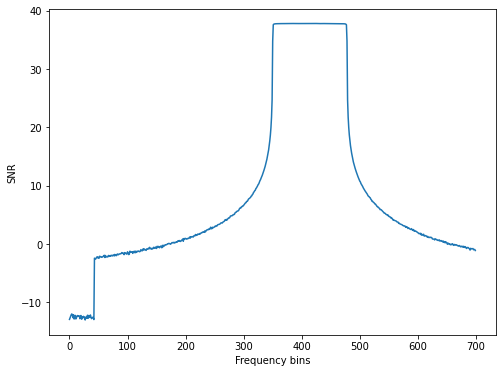

In [18]:
spectrum = stg.integrate(frame, normalize=False)

plt.figure(figsize=(8, 6))
plt.plot(stg.db(spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

In [5]:
vars(stg.voltage.PolyphaseFilterbank)

mappingproxy({'__module__': 'setigen.voltage.polyphase_filterbank',
              '__doc__': '\n    Implement a polyphase filterbank (PFB) for coarse channelization of real voltage input data.\n    \n    Follows description in Danny C. Price, Spectrometers and Polyphase Filterbanks in \n    Radio Astronomy, 2016. Available online at: http://arxiv.org/abs/1607.03579.\n    ',
              '__init__': <function setigen.voltage.polyphase_filterbank.PolyphaseFilterbank.__init__(self, num_taps=8, num_branches=1024, window_fn='hamming')>,
              '_reset_cache': <function setigen.voltage.polyphase_filterbank.PolyphaseFilterbank._reset_cache(self)>,
              '_get_channelized_stds': <function setigen.voltage.polyphase_filterbank.PolyphaseFilterbank._get_channelized_stds(self)>,
              '_get_pfb_window': <function setigen.voltage.polyphase_filterbank.PolyphaseFilterbank._get_pfb_window(self)>,
              'channelize': <function setigen.voltage.polyphase_filterbank.Polyphas

67747766.07208706
16936942.23113551
4234236.2707189955
4136.051677724199


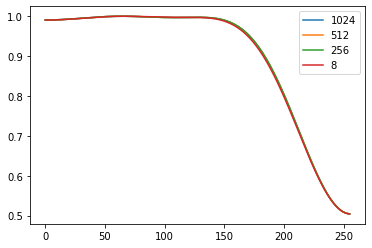

In [18]:
for num_branches in [1024, 512, 256, 8]:
    filterbank = stg.voltage.PolyphaseFilterbank(num_taps=8, 
                                                 num_branches=num_branches)
    response = filterbank.response
    print(cp.max(response))
    plt.plot(cp.asnumpy(response/cp.max(response)), label=f'{num_branches}')
plt.legend()
plt.show()

61023820.18788941
15255755.372692341
3813839.1260686256
3718.7261735364687


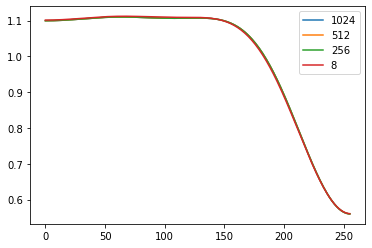

In [8]:
for num_branches in [1024, 512, 256, 8]:
    filterbank = stg.voltage.PolyphaseFilterbank(num_taps=8, 
                                                 num_branches=num_branches)
    response = filterbank.response
    print(cp.mean(response))
    plt.plot(cp.asnumpy(response/cp.mean(response)), label=f'{num_branches}')
plt.legend()
plt.show()

16777373.78674764
67747766.07208706
270471211.68189037
1079510675.8032188


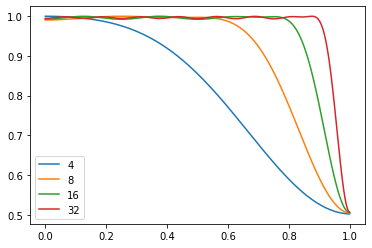

In [17]:
for num_taps in [4, 8, 16, 32]:
    filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                                 num_branches=1024)
    response = filterbank.response
    print(cp.max(response))
    plt.plot(np.linspace(0, 1, len(response)), 
             cp.asnumpy(response/cp.max(response)), 
             label=f'{num_taps}')
plt.legend()
plt.show()

In [3]:
import numpy as np
np.empty(2).get_noise()

AttributeError: 'numpy.ndarray' object has no attribute 'get_noise'

In [ ]:
given tchans:
    
obsnchan = self.num_chans * self.num_antennas
self.bytes_per_sample = 2 * self.num_pols * self.num_bits // 8

T = int(self.block_size / (obsnchan * self.bytes_per_sample))

block_size = T * obsnchan * self.bytes_per_sample

condition is that T is divisible by num_taps

self.block_size % int(obsnchan * self.num_taps * self.bytes_per_sample) == 0


T is raw number of time channels.
then...

tchans = T / fftlength / int_factor?





In [9]:
block_size = 134217728//16
block_size

8388608

In [10]:
block_size // (4 * 1) // (2 * 2 * 8 // 8)

524288.0

In [12]:
block_size // (4 * 1) // (2 * 2 * 8 // 8) // 1024 // 4

128

In [5]:
stg.voltage.get_block_size(1, 128, 8, 2, 1024, 4, 1024, 4)

8388608

In [6]:
134217728//16

8388608

In [26]:
!rawspec -f $fftlength -t $int_factor -d . drifting


working stem: drifting
opening file: drifting.0000.raw
opening file: drifting.0001.raw
opening file: drifting.0002.raw
opening file: drifting.0003.raw
opening file: drifting.0004.raw
opening file: drifting.0005.raw
opening file: drifting.0006.raw
opening file: drifting.0007.raw
opening file: drifting.0008.raw
opening file: drifting.0009.raw
opening file: drifting.0010.raw
opening file: drifting.0011.raw
opening file: drifting.0012.raw
opening file: drifting.0013.raw
opening file: drifting.0014.raw [No such file or directory]
output product 0: 16 spectra


working stem: drifting
opening file: drifting.0000.raw
opening file: drifting.0001.raw
opening file: drifting.0002.raw
opening file: drifting.0003.raw
opening file: drifting.0004.raw
opening file: drifting.0005.raw
opening file: drifting.0006.raw
opening file: drifting.0007.raw
opening file: drifting.0008.raw
opening file: drifting.0009.raw
opening file: drifting.0010.raw
opening file: drifting.0011.raw
opening file: drifting.0012.raw
opening file: drifting.0013.raw
opening file: drifting.0014.raw [No such file or directory]
output product 0: 16 spectra


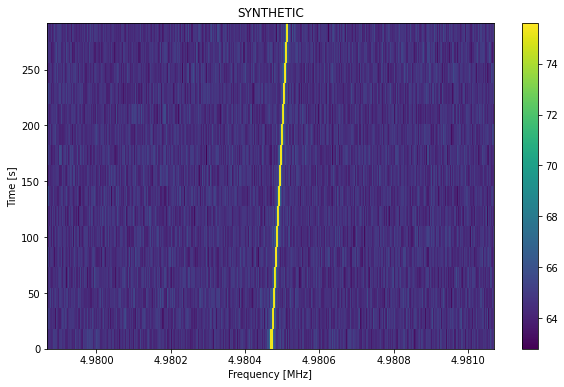

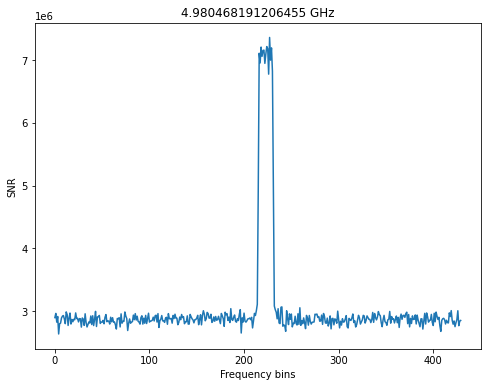

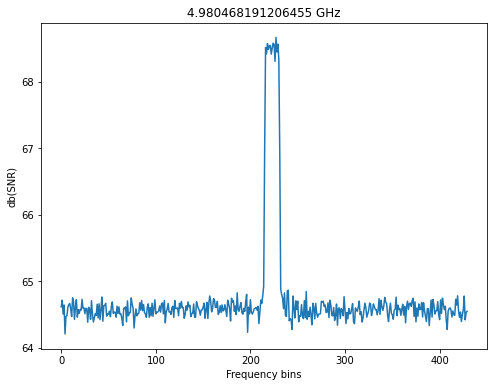

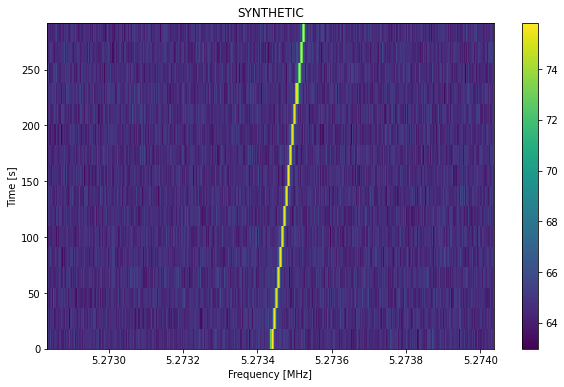

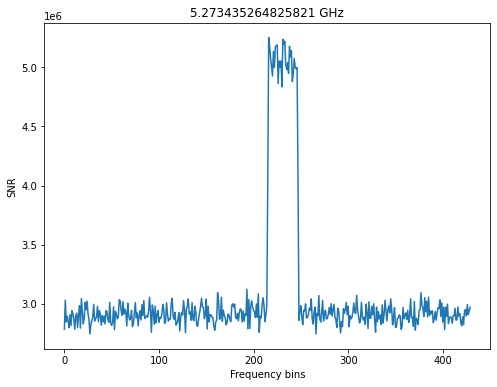

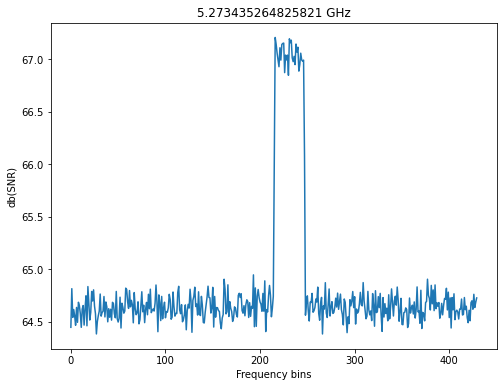

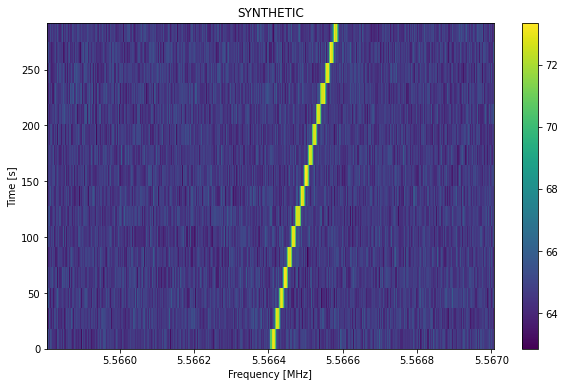

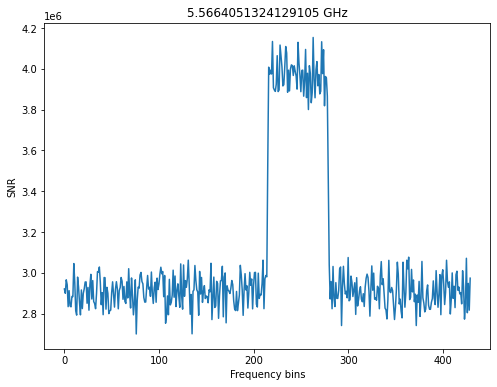

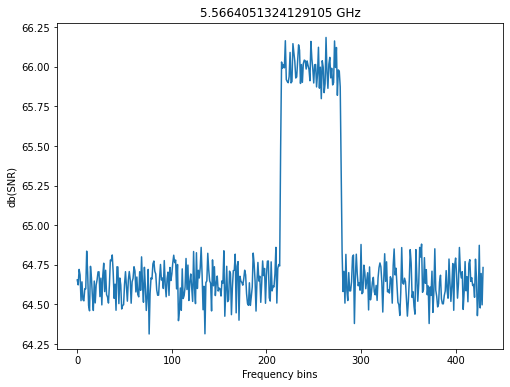

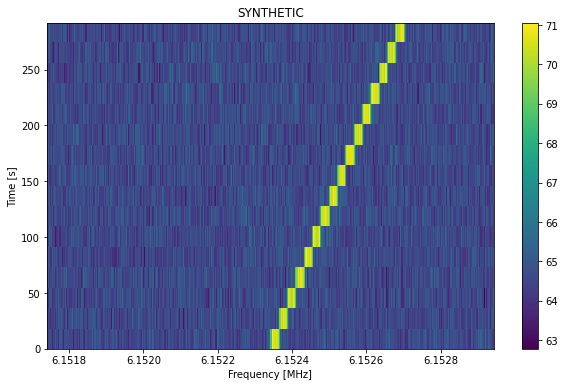

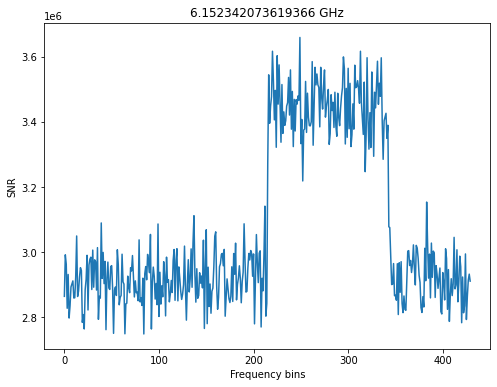

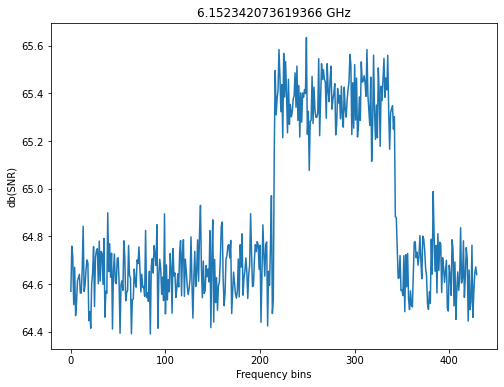

In [29]:
!rawspec -f $fftlength -t $int_factor -d . drifting

for f_start in [fine_chan_bw * int(fftlength*(2+0.2-0.5)), 
                fine_chan_bw * int(fftlength*(2+0.3-0.5)), 
                fine_chan_bw * int(fftlength*(2+0.4-0.5)), 
                fine_chan_bw * int(fftlength*(2+0.6-0.5)),]:

    wf = bl.Waterfall('drifting.rawspec.0000.fil',
                      f_start=f_start/1e6 - 3*200/1e6,
                      f_stop=f_start/1e6 + 3*200/1e6)

    plt.figure(figsize=(10, 6))
    wf.plot_waterfall()
    plt.show()

    frame = stg.Frame(wf)

    spectrum = stg.integrate(frame, normalize=False)

    plt.figure(figsize=(8, 6))
    plt.plot(spectrum)
    plt.xlabel('Frequency bins')
    plt.ylabel('SNR')
    plt.title(f"{f_start/1e6} GHz")
    plt.show()

    spectrum = stg.integrate(frame, normalize=False)

    plt.figure(figsize=(8, 6))
    plt.plot(stg.db(spectrum))
    plt.xlabel('Frequency bins')
    plt.ylabel('db(SNR)')
    plt.title(f"{f_start/1e6} GHz")
    plt.show()

working stem: drifting_no_noise
opening file: drifting_no_noise.0000.raw
opening file: drifting_no_noise.0001.raw
opening file: drifting_no_noise.0002.raw
opening file: drifting_no_noise.0003.raw
opening file: drifting_no_noise.0004.raw
opening file: drifting_no_noise.0005.raw
opening file: drifting_no_noise.0006.raw
opening file: drifting_no_noise.0007.raw
opening file: drifting_no_noise.0008.raw
opening file: drifting_no_noise.0009.raw
opening file: drifting_no_noise.0010.raw
opening file: drifting_no_noise.0011.raw
opening file: drifting_no_noise.0012.raw
opening file: drifting_no_noise.0013.raw
opening file: drifting_no_noise.0014.raw [No such file or directory]
output product 0: 16 spectra


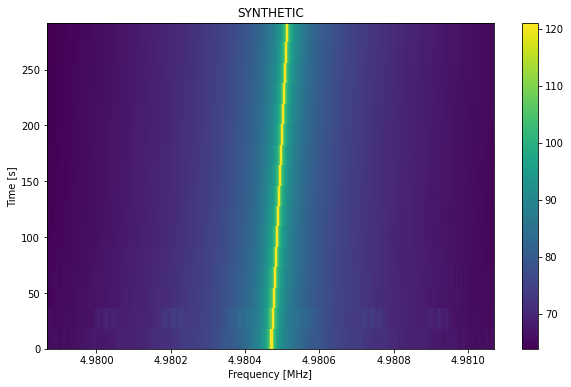

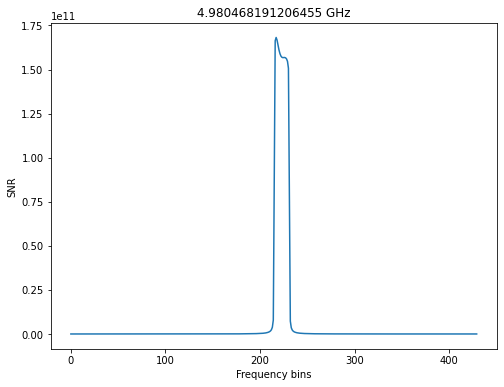

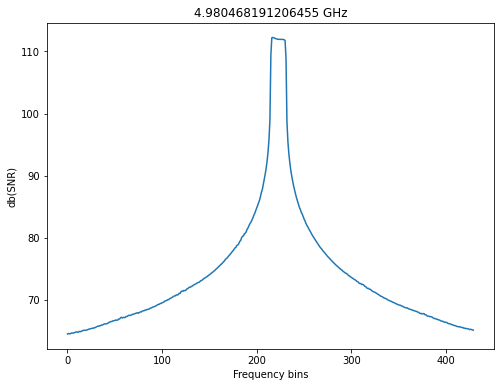

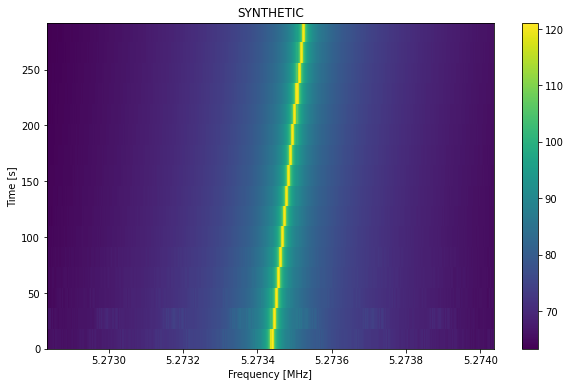

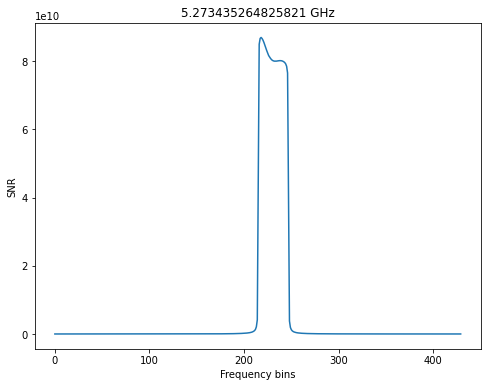

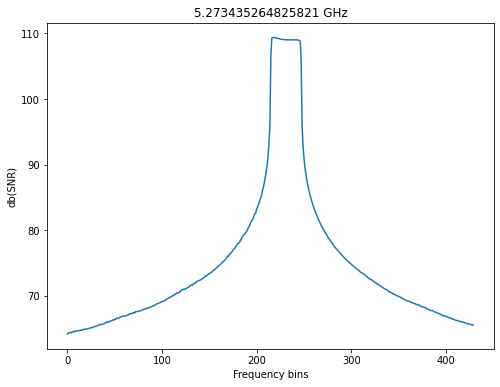

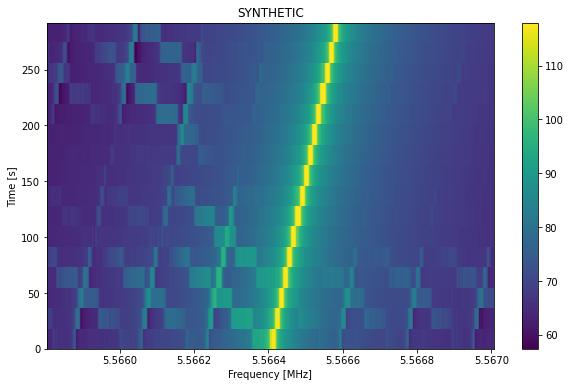

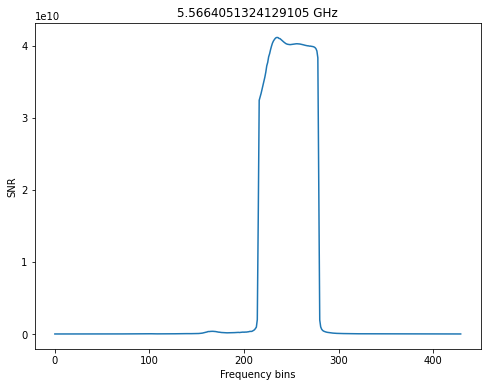

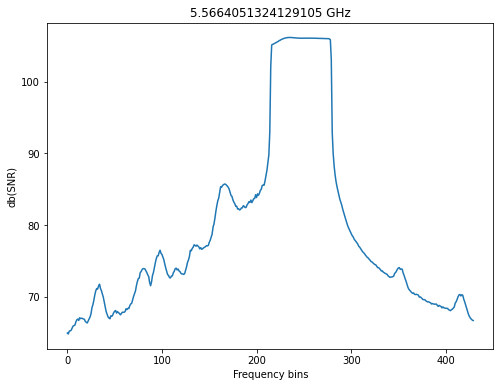

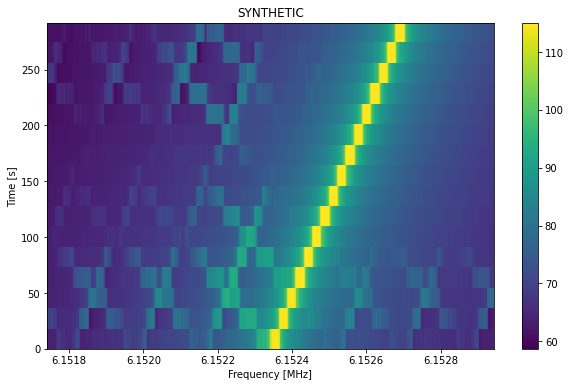

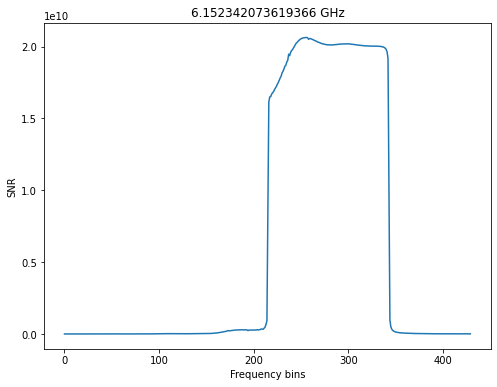

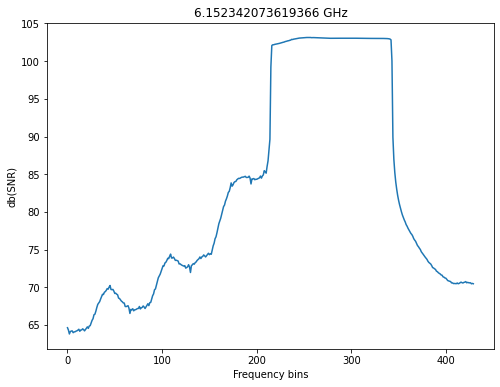

In [90]:
!rawspec -f $fftlength -t $int_factor -d . drifting_no_noise

for f_start in [fine_chan_bw * int(fftlength*(2+0.2-0.5)), 
                fine_chan_bw * int(fftlength*(2+0.3-0.5)), 
                fine_chan_bw * int(fftlength*(2+0.4-0.5)), 
                fine_chan_bw * int(fftlength*(2+0.6-0.5)),]:

    wf = bl.Waterfall('drifting_no_noise.rawspec.0000.fil',
                      f_start=f_start/1e6 - 3*200/1e6,
                      f_stop=f_start/1e6 + 3*200/1e6)

    plt.figure(figsize=(10, 6))
    wf.plot_waterfall()
    plt.show()

    frame = stg.Frame(wf)

    spectrum = stg.integrate(frame, normalize=False)

    plt.figure(figsize=(8, 6))
    plt.plot(spectrum)
    plt.xlabel('Frequency bins')
    plt.ylabel('SNR')
    plt.title(f"{f_start/1e6} GHz")
    plt.show()

    spectrum = stg.integrate(frame, normalize=False)

    plt.figure(figsize=(8, 6))
    plt.plot(stg.db(spectrum))
    plt.xlabel('Frequency bins')
    plt.ylabel('db(SNR)')
    plt.title(f"{f_start/1e6} GHz")
    plt.show()

In [9]:
sample_rate = 3e9 // 1
num_taps = 8
num_branches = 1024 // 1

fftlength = 1048576
int_factor = 51
obs_length = 300

chan_bw = sample_rate / num_branches
fine_chan_bw = chan_bw / fftlength

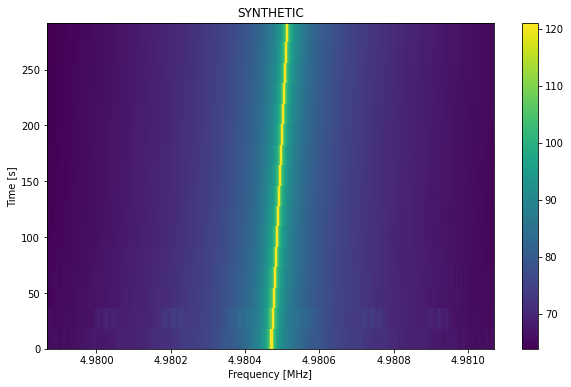

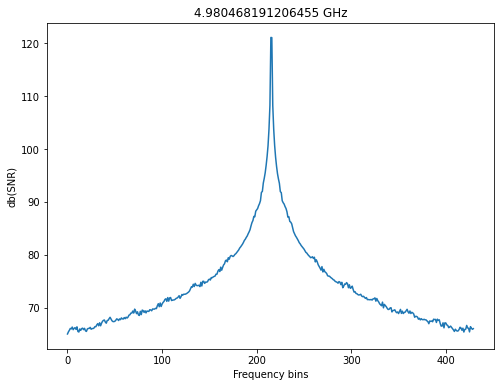

In [10]:
f_start = fine_chan_bw * int(fftlength*(2+0.2-0.5))

wf = bl.Waterfall('drifting_no_noise.rawspec.0000.fil',
                  f_start=f_start/1e6 - 3*200/1e6,
                  f_stop=f_start/1e6 + 3*200/1e6)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

# spectrum = stg.integrate(frame, normalize=False)

# plt.figure(figsize=(8, 6))
# plt.plot(spectrum)
# plt.xlabel('Frequency bins')
# plt.ylabel('SNR')
# plt.title(f"{f_start/1e6} GHz")
# plt.show()

# spectrum = stg.integrate(frame, normalize=False)


plt.figure(figsize=(8, 6))
for i in range(1):
    spectrum = frame.data[i]
    plt.plot(stg.db(spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.title(f"{f_start/1e6} GHz")
plt.show()

In [43]:
frame.shape

(16, 430)

In [46]:
s_fr = stg.Frame.from_backend_params(frame.fchans, frame.tchans)
s_fr.shape

(16, 430)

In [55]:
stg.sinc2_f_profile?

Signature: stg.sinc2_f_profile(width, trunc=True)
Docstring:
Sinc squared profile; width is the FWHM of the squared normalized sinc function.

The trunc parameter controls whether or not the sinc squared profile is 
truncated at the first root (e.g. zeroed out for more distant frequencies).
File:      /mnt_home/bryanb/setigen/setigen/funcs/f_profiles.py
Type:      function


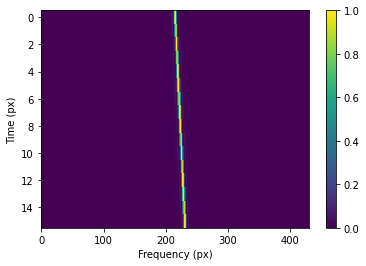

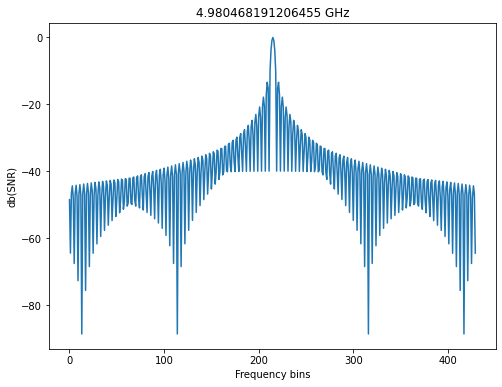

In [14]:
s_fr = stg.Frame.from_backend_params(frame.fchans, frame.tchans)
s_fr.add_signal(stg.constant_path(f_start=s_fr.get_frequency(index=s_fr.fchans//2),
                                  drift_rate=frame.df/frame.dt),
                          stg.constant_t_profile(level=1),
                          stg.sinc2_f_profile(width=10, trunc=False),
                          stg.constant_bp_profile(level=1))
s_fr.plot()
plt.show()

# s_fr.data += 1e-12
plt.figure(figsize=(8, 6))
for i in range(1):
    spectrum = s_fr.data[i]
    plt.plot(stg.db(spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.title(f"{f_start/1e6} GHz")
plt.show()

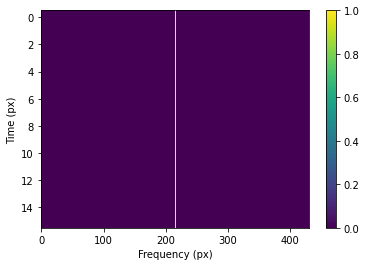

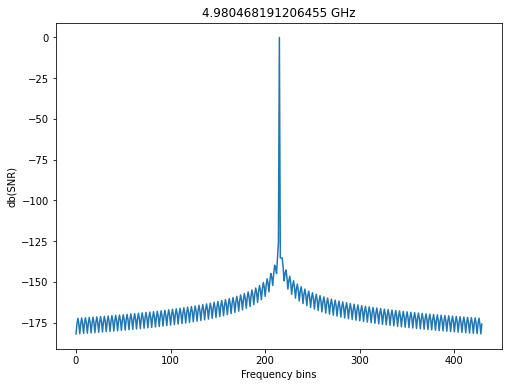

In [38]:
s_fr = stg.Frame.from_backend_params(frame.fchans, frame.tchans)
s_fr.add_signal(stg.constant_path(f_start=s_fr.get_frequency(index=s_fr.fchans//2),
                                  drift_rate=0),
                          stg.constant_t_profile(level=1),
                          stg.sinc2_f_profile(width=s_fr.df, 
                                              width_mode='cross',
                                              trunc=False),
                          stg.constant_bp_profile(level=1))
s_fr.plot()
plt.show()

# s_fr.data += 1e-12
plt.figure(figsize=(8, 6))
spectrum = s_fr.data[0]
plt.plot(stg.db(spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.title(f"{f_start/1e6} GHz")
plt.show()

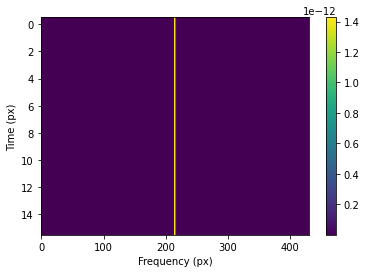

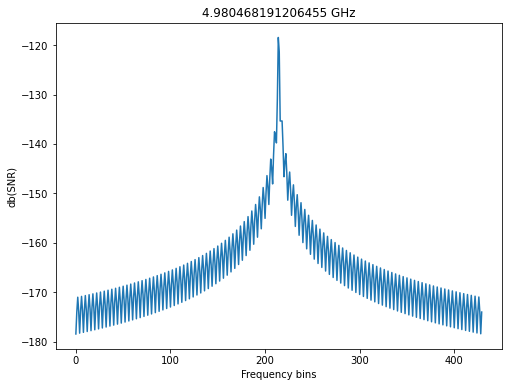

In [72]:
s_fr = stg.Frame.from_backend_params(frame.fchans, frame.tchans)
s_fr.add_signal(stg.constant_path(f_start=s_fr.get_frequency(index=s_fr.fchans//2)-s_fr.df/2,
                                  drift_rate=0),
                          stg.constant_t_profile(level=1),
                          stg.sinc2_f_profile(width=s_fr.df, 
                                              width_mode='cross',
                                              trunc=False),
                          stg.constant_bp_profile(level=1))
s_fr.plot()
plt.show()

# s_fr.data += 1e-12
plt.figure(figsize=(8, 6))
spectrum = s_fr.data[0]
plt.plot(stg.db(spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.title(f"{f_start/1e6} GHz")
plt.show()

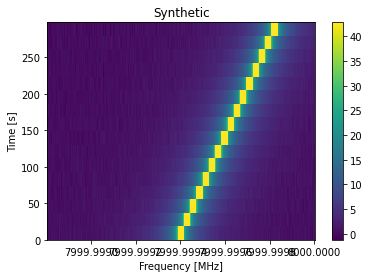

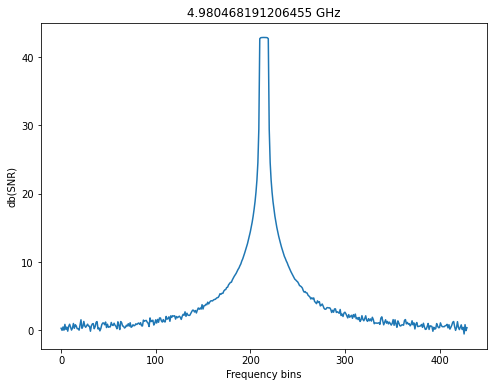

In [89]:
def smeared_sinc2(drift_rate, df, dt, steps=10):
    def f_profile(f, f_center):
        s_range = drift_rate * dt
        s_steps = np.linspace(-s_range/2, s_range/2, steps)
        prof = np.zeros(f.shape)
        for s_center in s_steps:
            prof += np.sinc((f - f_center - s_center)/(df/2))**2
        return prof
    return f_profile

s_fr = stg.Frame.from_backend_params(frame.fchans, frame.tchans)

drift_factor = 10
drift_rate = s_fr.df/s_fr.dt * drift_factor

s_fr.add_noise(1)
s_fr.add_signal(stg.constant_path(f_start=s_fr.get_frequency(index=s_fr.fchans//2)-s_fr.df/2,
                                  drift_rate=drift_rate),
                          stg.constant_t_profile(level=10000),
                          smeared_sinc2(drift_rate, 
                                        s_fr.df, 
                                        s_fr.dt,
                                        steps=int(drift_factor*4)),
                          stg.constant_bp_profile(level=1))
s_fr.bl_plot()
plt.show()

# s_fr.data += 1e-12
plt.figure(figsize=(8, 6))
for i in range(1):
    spectrum = s_fr.data[i]
    plt.plot(stg.db(spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('db(SNR)')
plt.title(f"{f_start/1e6} GHz")
plt.show()